<a href="https://colab.research.google.com/github/mikethebos/CS523-Assignment-3/blob/main/fashion_mnist_ca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Self-classifying Neural Cellular Automata](https://distill.pub/2020/selforg-mnist/)

This notebook contains code to reproduce experiments and figures for the "Self-classifying Neural Cellular Automata" article.

*Copyright 2020 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title imports and notebook utils
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

##Load MNIST

4431872/4422102 [==============================] - 0s 0us/step
Generating y pics...


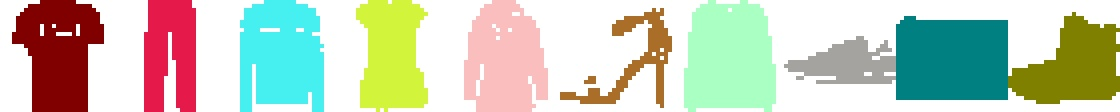

Storing x_legend for use in the demo.


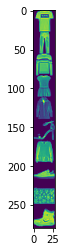

In [2]:
# @title Generate train/test set from MNIST.

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)

# @title Data generator
color_lookup = tf.constant([
            [128, 0, 0],
            [230, 25, 75],
            [70, 240, 240],
            [210, 245, 60],
            [250, 190, 190],
            [170, 110, 40],
            [170, 255, 195],
            [165, 163, 159],
            [0, 128, 128],
            [128, 128, 0],
            [0, 0, 0], # This is the default for digits.
            [255, 255, 255] # This is the background.
            ])

backgroundWhite = True
def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
  # works for shapes of x [b, r, c] and [r, c]
  black_and_white = tf.fill(list(x.shape) + [2], 0.01)
  is_gray = tf.cast(x > 0.1, tf.float32)
  is_not_gray = 1. - is_gray

  y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
  # if disable_black, make is_gray super low.
  if disable_black:
    is_gray *= -1e5
    # this ensures that you don't draw white in the digits.
    is_not_gray += is_gray

  bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
  black_and_white *= tf.stack(bnw_order, -1)

  rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
  if dtype == tf.uint8:
    return tf.cast(rgb, tf.uint8)
  else:
    return tf.cast(rgb, dtype) / 255.

def to_ten_dim_label(x, y):
  # x shape is [b, r, c]
  # y shape is [b]

  # y_res shape is [b, r, c, 10]
  y_res = np.zeros(list(x.shape) + [10])
  # broadcast y to match x shape:
  y_expanded = np.broadcast_to(y, x.T.shape).T
  y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
  return y_res.astype(np.float32)

def find_different_numbers(x_set, y_set, y_set_pic, orientation="vertical"):
  result_y = []
  result_x = []
  for i in range(10):
    for x, y, y_pic in zip(x_set, y_set, y_set_pic):
      if y == i:
        result_y.append(color_labels(x, y_pic))
        result_x.append(x)
        break
  assert len(result_y) == 10

  result_y = np.concatenate(result_y, axis=0 if orientation == "vertical" else 1)
  result_x = np.stack(result_x)

  return result_y, result_x


print("Generating y pics...")
y_train_pic = to_ten_dim_label(x_train, y_train)
y_test_pic = to_ten_dim_label(x_test, y_test)


numbers_legend, x_legend = find_different_numbers(x_train, y_train, y_train_pic)
numbers_legend_horiz, _ = find_different_numbers(x_train, y_train, y_train_pic, "horizontal")

imshow(zoom(numbers_legend_horiz))
print("Storing x_legend for use in the demo.")
pl.imshow(x_legend.reshape((-1, 28)))
import json
samples_str = json.dumps(x_legend.tolist())


## Cellular Automata parameters

In [3]:
#@markdown ### Model configuration
#@markdown These options configure the model to be used and train in this 
#@markdown notebook. Please refer to the article for more information.
CHANNEL_N = 19 # Number of CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5

MODEL_TYPE = '3 mutating'  #@param ['1 naive', '2 persistent', '3 mutating']
LOSS_TYPE = "l2"  #@param ['l2', 'ce']
ADD_NOISE = "True"  #@param ['True', 'False']

USE_PATTERN_POOL, MUTATE_POOL = {
    '1 naive': (False, False),
    '2 persistent': (True, False),
    '3 mutating': (True, True)
    }[MODEL_TYPE]
ADD_NOISE = ADD_NOISE == 'True'

In [4]:
#@title CA model and utils

from tensorflow.keras.layers import Conv2D

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does *not* include the greyscale channel.
    # but it does include the 10 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n])
    images = tf.reshape(images, [-1, 28, 28, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # The last 10 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-10:]

CAModel().perceive.summary()
CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 80)             14480     
                                                                 
Total params: 14,480
Trainable params: 14,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_5 (Conv2D)           (1, 3, 3, 19)             1539      
                                                                 
Total params: 8,019
Trainable params: 8,019
Non-trainable params: 0
_________________________________________________________________


# Training and visualization utils

In [5]:
#@title Train utils (SamplePool, model export, visualizations)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None 
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N+1]),
      fire_rate=tf.constant(0.5),
      manual_noise=tf.TensorSpec([None, None, None, CHANNEL_N]))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def classify_and_color(ca, x, disable_black=False):
  return color_labels(
      x[:,:,:,0], ca.classify(x), disable_black, dtype=tf.float32)


def generate_tiled_figures(figures, fade_by=0.1):
  tiled_pool = tile2d(figures)
  fade_sz = int(tiled_pool.shape[0] * fade_by)
  fade = np.linspace(1.0, 0.0, fade_sz)
  ones = np.ones(fade_sz) 
  tiled_pool[:, :fade_sz] += (-tiled_pool[:, :fade_sz] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -fade_sz:] += (-tiled_pool[:, -fade_sz:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:fade_sz, :] += (-tiled_pool[:fade_sz, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-fade_sz:, :] += (-tiled_pool[-fade_sz:, :] + ones[:, None, None]) * fade[::-1, None, None]
  return tiled_pool

def generate_pool_figures(ca, pool, step_i):
  tiled_pool = tile2d(classify_and_color(ca, pool.x))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(ca, x0, x, step_i):
  vis0 = np.hstack(classify_and_color(ca, x0).numpy())
  vis1 = np.hstack(classify_and_color(ca, x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


# Evaluation functions

  0%|          | 0/10 [00:00<?, ?it/s]

[[169847.  65228. 162159.  97124. 156771.  36548. 155374.  45356. 118093.
   85785.]
 [ 12175.  91825.  48112.  15366.  26665.   4406.  19202.    922.   8253.
    4555.]
 [ 40495.  22021.  67532.  30563.  62703.   3532.  51959.   4465.  23897.
   15758.]
 [ 26409.  38375.  35799.  35888.  34394.   7918.  32295.   5284.  17798.
   15585.]
 [ 34083.  15305.  41643.  34696.  57615.   1425.  31153.   2565.  20536.
   18463.]
 [ 10979.   1950.   7860.   6733.   4068.  33130.   8850.  16727.  12029.
    5389.]
 [  8666.   1446.  10431.   3508.   4008.   1015.  12313.    752.   2970.
     850.]
 [ 11329.   2171.   8625.   4513.   6808.  21428.   7650.  31318.   8474.
   10260.]
 [103113.  22942. 120168.  41937. 130703.  24005.  95290.  50127. 152126.
   73681.]
 [ 28464.   7707.  28831.  16302.  35655.  35733.  23254.  59094.  35564.
   84224.]]
[[7.256125e+06 1.678140e+05 1.392382e+06 2.370944e+06 1.374806e+06
  1.498960e+05 2.940939e+06 1.271620e+05 6.786640e+05 2.408040e+05]
 [4.141600e+04

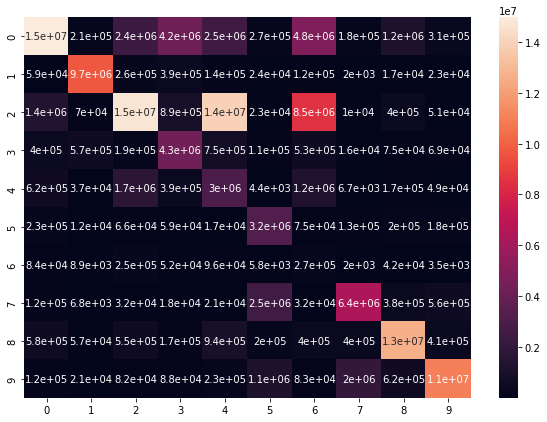

 10%|█         | 1/10 [00:47<07:03, 47.05s/it]

[[1.5119132e+07 2.7437600e+05 2.5877680e+06 4.2621900e+06 2.6267210e+06
  3.1738400e+05 4.9725280e+06 2.3059000e+05 1.2788700e+06 3.9615200e+05]
 [6.9267000e+04 9.8281270e+06 3.0320600e+05 3.9998300e+05 1.6007800e+05
  3.1564000e+04 1.3789700e+05 2.8610000e+03 2.7653000e+04 2.7215000e+04]
 [1.4391110e+06 9.1810000e+04 1.4745324e+07 9.2075500e+05 1.4014073e+07
  2.7694000e+04 8.5410080e+06 1.4589000e+04 4.2200500e+05 6.7073000e+04]
 [4.2260700e+05 6.0447900e+05 2.2028500e+05 4.3513000e+06 7.8348700e+05
  1.1964800e+05 5.6240000e+05 2.0605000e+04 9.6216000e+04 8.5859000e+04]
 [6.5314100e+05 5.5071000e+04 1.7499590e+06 4.2829500e+05 3.0678700e+06
  6.1270000e+03 1.2710710e+06 9.2840000e+03 1.8825500e+05 6.5637000e+04]
 [2.3883600e+05 1.3432000e+04 7.0811000e+04 6.3998000e+04 2.0742000e+04
  3.2525360e+06 8.5398000e+04 1.4756700e+05 2.0824100e+05 1.8497300e+05]
 [9.3006000e+04 9.9700000e+03 2.6035900e+05 5.4332000e+04 1.0119700e+05
  6.8510000e+03 2.8051200e+05 3.0010000e+03 4.4652000e+04 

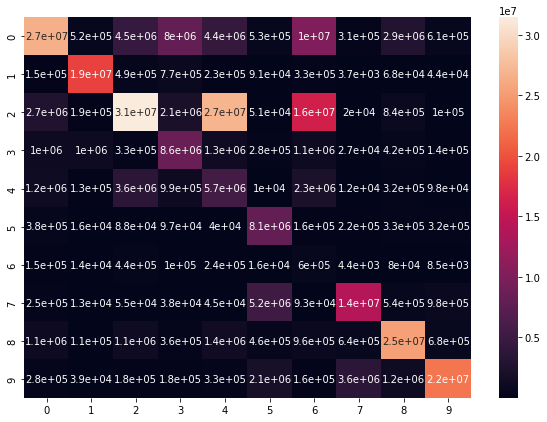

 20%|██        | 2/10 [01:33<06:11, 46.47s/it]

[[2.6818223e+07 5.8515200e+05 4.6210400e+06 8.1279810e+06 4.5047000e+06
  5.6452600e+05 1.0278774e+07 3.5447100e+05 3.0228300e+06 6.9729400e+05]
 [1.5886000e+05 1.9247015e+07 5.2457000e+05 7.8513100e+05 2.5084900e+05
  9.5366000e+04 3.4825300e+05 4.5430000e+03 7.8701000e+04 4.8740000e+04]
 [2.7451680e+06 2.1495500e+05 3.1514439e+07 2.1528470e+06 2.7005370e+07
  5.4518000e+04 1.6356125e+07 2.4300000e+04 8.6546000e+05 1.2019100e+05]
 [1.0512110e+06 1.0547140e+06 3.6553900e+05 8.6382380e+06 1.3579520e+06
  2.8924400e+05 1.1192720e+06 3.1176000e+04 4.3509600e+05 1.5776000e+05]
 [1.2215000e+06 1.4618600e+05 3.6681400e+06 1.0251770e+06 5.7078070e+06
  1.1125000e+04 2.3051400e+06 1.4772000e+04 3.4670000e+05 1.1485700e+05]
 [3.8680000e+05 1.8585000e+04 9.4709000e+04 1.0423100e+05 4.4555000e+04
  8.1156530e+06 1.6922300e+05 2.3656000e+05 3.4015200e+05 3.2979000e+05]
 [1.5540300e+05 1.4771000e+04 4.4620900e+05 1.0683400e+05 2.4435000e+05
  1.7326000e+04 6.1288600e+05 5.0820000e+03 8.2299000e+04 

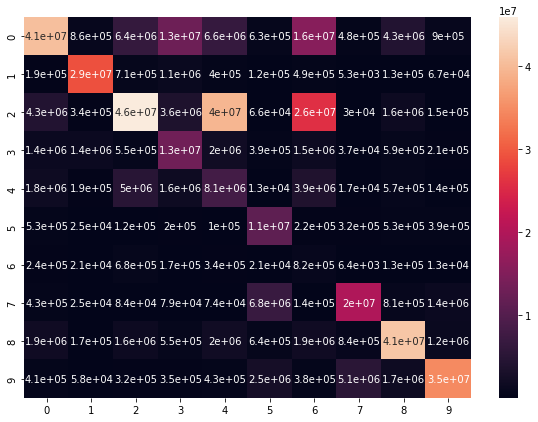

 30%|███       | 3/10 [02:18<05:22, 46.12s/it]

[[4.0665282e+07 9.1999800e+05 6.5943370e+06 1.2864194e+07 6.7060110e+06
  6.7340600e+05 1.5831046e+07 5.4143500e+05 4.4292790e+06 9.8428000e+05]
 [2.0550700e+05 2.9161635e+07 7.4682800e+05 1.1438330e+06 4.2761100e+05
  1.2840900e+05 5.1179200e+05 6.3670000e+03 1.3964900e+05 7.1839000e+04]
 [4.3290370e+06 3.5423500e+05 4.5926463e+07 3.6303110e+06 3.9574646e+07
  6.9969000e+04 2.5864665e+07 3.5479000e+04 1.6289480e+06 1.7020600e+05]
 [1.4063370e+06 1.4250060e+06 5.8853200e+05 1.3287881e+07 2.0258920e+06
  4.0657900e+05 1.5517080e+06 4.3274000e+04 6.1566300e+05 2.2789500e+05]
 [1.8187440e+06 1.9866600e+05 5.0308620e+06 1.6738480e+06 8.1552720e+06
  1.4675000e+04 3.9594250e+06 2.0406000e+04 5.9189700e+05 1.6211900e+05]
 [5.4561400e+05 2.6487000e+04 1.3086300e+05 2.1240300e+05 1.0750300e+05
  1.1271376e+07 2.2555600e+05 3.4588300e+05 5.4390900e+05 3.9021100e+05]
 [2.4304100e+05 2.1350000e+04 6.9078800e+05 1.7647500e+05 3.4301300e+05
  2.1984000e+04 8.3287200e+05 7.4190000e+03 1.3268600e+05 

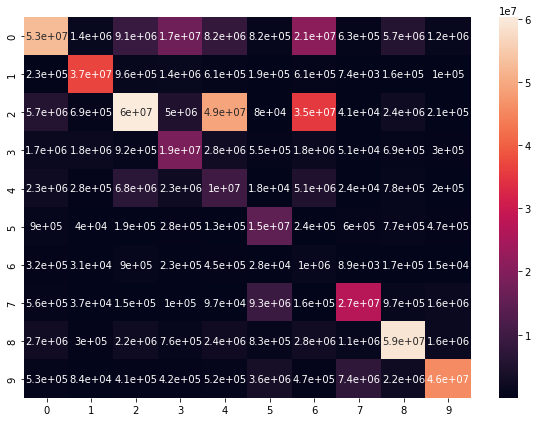

 40%|████      | 4/10 [03:05<04:38, 46.44s/it]

[[5.2764727e+07 1.4407660e+06 9.2127680e+06 1.7081850e+07 8.3756420e+06
  8.5871200e+05 2.1191898e+07 6.6840500e+05 5.8019880e+06 1.2635110e+06]
 [2.4282600e+05 3.6872473e+07 9.9670900e+05 1.4250570e+06 6.3603900e+05
  1.9886700e+05 6.2995300e+05 8.1720000e+03 1.6705500e+05 1.0890600e+05]
 [5.7380670e+06 7.0155000e+05 6.0291600e+07 5.0489400e+06 4.9442289e+07
  8.3708000e+04 3.5365342e+07 4.5425000e+04 2.3846230e+06 2.2857500e+05]
 [1.7504260e+06 1.8287560e+06 9.5127800e+05 1.8784737e+07 2.7960560e+06
  5.5793300e+05 1.8411320e+06 5.5020000e+04 7.1138500e+05 3.1506100e+05]
 [2.3157590e+06 2.9605700e+05 6.8000460e+06 2.3489880e+06 1.0169310e+07
  1.9558000e+04 5.0913500e+06 2.6107000e+04 8.0409300e+05 2.1601800e+05]
 [9.0718700e+05 4.3084000e+04 1.9636100e+05 2.8755400e+05 1.3679300e+05
  1.4835287e+07 2.5149000e+05 6.1597400e+05 7.7905900e+05 4.7365200e+05]
 [3.2388900e+05 3.2081000e+04 9.1283700e+05 2.3631900e+05 4.4995000e+05
  2.8095000e+04 1.0055500e+06 9.7050000e+03 1.6855500e+05 

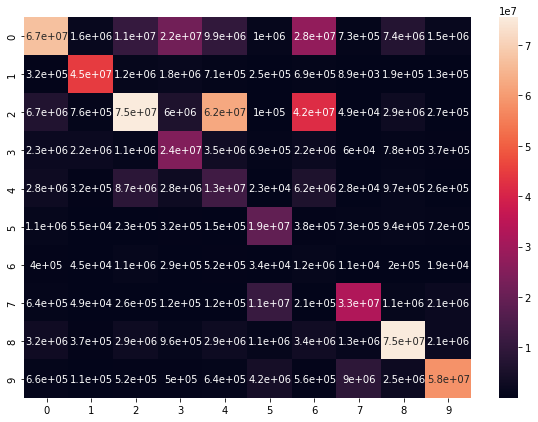

 50%|█████     | 5/10 [03:53<03:54, 46.81s/it]

[[6.7243292e+07 1.6384730e+06 1.0973898e+07 2.1964782e+07 1.0088179e+07
  1.0614360e+06 2.7679401e+07 7.7189800e+05 7.4638170e+06 1.6059880e+06]
 [3.2894100e+05 4.4680927e+07 1.2142650e+06 1.7776820e+06 7.3437300e+05
  2.5643600e+05 7.1137000e+05 9.7380000e+03 1.9912500e+05 1.3685100e+05]
 [6.7384850e+06 7.7686200e+05 7.5315228e+07 6.0710740e+06 6.2379062e+07
  1.0516500e+05 4.1979958e+07 5.3432000e+04 2.9256830e+06 2.8717200e+05]
 [2.3270600e+06 2.2446480e+06 1.1520640e+06 2.4522805e+07 3.5095290e+06
  7.0324400e+05 2.2769290e+06 6.5312000e+04 7.9463800e+05 3.8884200e+05]
 [2.7875950e+06 3.2963600e+05 8.7518540e+06 2.8413030e+06 1.2780227e+07
  2.5039000e+04 6.2191340e+06 3.0687000e+04 9.9194300e+05 2.7890700e+05]
 [1.0752100e+06 5.7180000e+04 2.3869500e+05 3.2357000e+05 1.5046700e+05
  1.9040904e+07 3.9106700e+05 7.4440700e+05 9.5101900e+05 7.2302500e+05]
 [4.0702500e+05 4.5674000e+04 1.1190550e+06 2.9411600e+05 5.2778200e+05
  3.4941000e+04 1.1984550e+06 1.1285000e+04 2.0558100e+05 

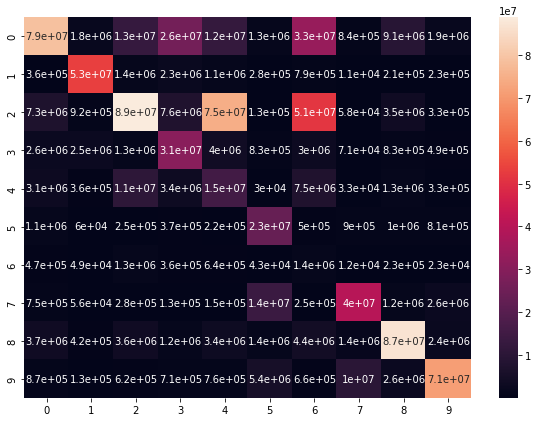

 60%|██████    | 6/10 [04:37<03:04, 46.06s/it]

[[7.8976869e+07 1.8808680e+06 1.2727080e+07 2.6420628e+07 1.2316658e+07
  1.3223800e+06 3.3500625e+07 8.8065300e+05 9.2551340e+06 1.9837140e+06]
 [3.6614000e+05 5.3309278e+07 1.4064890e+06 2.3443150e+06 1.1534730e+06
  2.8850700e+05 8.1015100e+05 1.1711000e+04 2.1633700e+05 2.3179500e+05]
 [7.3245930e+06 9.4414700e+05 8.8887611e+07 7.6508060e+06 7.4797281e+07
  1.3422900e+05 5.1457484e+07 6.2101000e+04 3.5555930e+06 3.4403200e+05]
 [2.6339260e+06 2.5837620e+06 1.2899790e+06 3.0711498e+07 4.0419030e+06
  8.4446000e+05 3.0035170e+06 7.6416000e+04 8.4678600e+05 5.0828500e+05]
 [3.1561480e+06 3.8212700e+05 1.0737135e+07 3.4094940e+06 1.5519246e+07
  3.1727000e+04 7.4878770e+06 3.5919000e+04 1.2892790e+06 3.4383400e+05]
 [1.1448190e+06 6.1880000e+04 2.6141100e+05 3.7291200e+05 2.1960200e+05
  2.3313704e+07 5.0813700e+05 9.1980500e+05 1.0466370e+06 8.1998200e+05]
 [4.7842500e+05 5.0218000e+04 1.2664330e+06 3.6262000e+05 6.4648600e+05
  4.4314000e+04 1.4064080e+06 1.3078000e+04 2.3036700e+05 

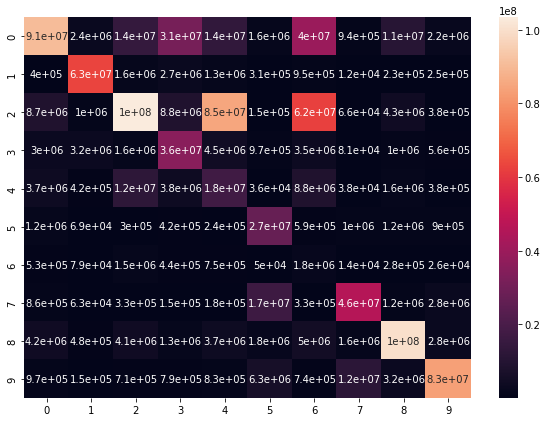

 70%|███████   | 7/10 [05:22<02:16, 45.55s/it]

[[9.10440580e+07 2.50432700e+06 1.43352220e+07 3.13670700e+07
  1.38310330e+07 1.60772600e+06 3.98979780e+07 9.92552000e+05
  1.08663090e+07 2.27270600e+06]
 [4.06104000e+05 6.34733380e+07 1.62259800e+06 2.70613700e+06
  1.30644200e+06 3.15560000e+05 9.69727000e+05 1.33200000e+04
  2.34599000e+05 2.50445000e+05]
 [8.74924000e+06 1.05804300e+06 1.03485223e+08 8.83266400e+06
  8.52465920e+07 1.53813000e+05 6.24706510e+07 7.03850000e+04
  4.27481400e+06 3.99502000e+05]
 [3.01281000e+06 3.24485500e+06 1.64337700e+06 3.56740250e+07
  4.50186000e+06 9.85312000e+05 3.52975700e+06 8.66900000e+04
  1.01712900e+06 5.77088000e+05]
 [3.75219300e+06 4.37298000e+05 1.21911790e+07 3.88779300e+06
  1.77003650e+07 3.86740000e+04 8.80251500e+06 4.08820000e+04
  1.63492300e+06 4.00170000e+05]
 [1.24232200e+06 7.01310000e+04 3.08570000e+05 4.25147000e+05
  2.48173000e+05 2.74174800e+07 5.98390000e+05 1.05248400e+06
  1.16197500e+06 9.07485000e+05]
 [5.42336000e+05 7.97000000e+04 1.46150000e+06 4.50372000e

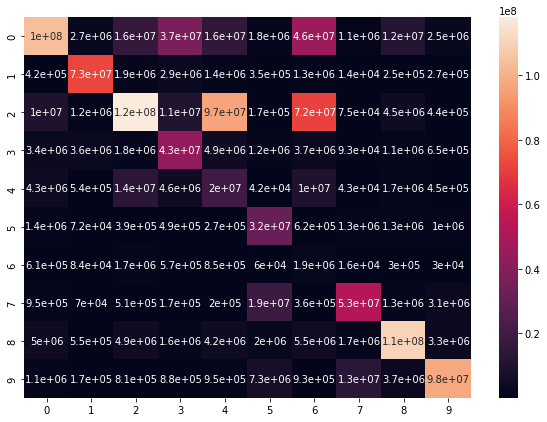

 80%|████████  | 8/10 [06:06<01:30, 45.14s/it]

[[1.04182753e+08 2.77121700e+06 1.64651250e+07 3.66069390e+07
  1.58156650e+07 1.84135000e+06 4.58376230e+07 1.11579900e+06
  1.17924460e+07 2.61478800e+06]
 [4.36271000e+05 7.26500880e+07 1.88632000e+06 2.94111300e+06
  1.40873300e+06 3.60342000e+05 1.31118100e+06 1.52140000e+04
  2.55783000e+05 2.80701000e+05]
 [1.00643430e+07 1.24169300e+06 1.18049730e+08 1.09476380e+07
  9.66936690e+07 1.72075000e+05 7.18863680e+07 8.02440000e+04
  4.52785400e+06 4.59950000e+05]
 [3.40745300e+06 3.66323300e+06 1.81233200e+06 4.29736670e+07
  4.97529200e+06 1.19167500e+06 3.72461400e+06 9.92900000e+04
  1.07346100e+06 6.63863000e+05]
 [4.33831800e+06 5.60467000e+05 1.37582380e+07 4.60183400e+06
  1.98624000e+07 4.32750000e+04 1.00518640e+07 4.69270000e+04
  1.72266400e+06 4.66368000e+05]
 [1.35726200e+06 7.44870000e+04 3.95944000e+05 4.94134000e+05
  2.75210000e+05 3.16041230e+07 6.29875000e+05 1.31150500e+06
  1.27442600e+06 1.00201500e+06]
 [6.15853000e+05 8.58120000e+04 1.68172700e+06 5.70044000e

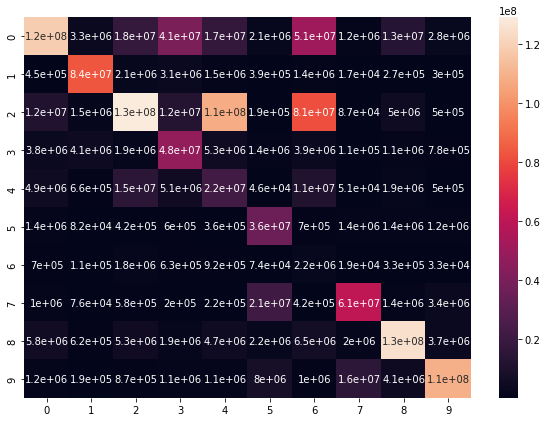

 90%|█████████ | 9/10 [06:50<00:44, 44.82s/it]

[[1.18774534e+08 3.40123100e+06 1.81819760e+07 4.09103930e+07
  1.72800710e+07 2.12010500e+06 5.14260030e+07 1.25520900e+06
  1.29460620e+07 2.90391100e+06]
 [4.65416000e+05 8.37540530e+07 2.14082700e+06 3.07700200e+06
  1.53471200e+06 3.96058000e+05 1.42133000e+06 1.73040000e+04
  2.79262000e+05 3.04532000e+05]
 [1.15983970e+07 1.55625900e+06 1.29109244e+08 1.21813270e+07
  1.08269430e+08 1.91403000e+05 8.12946080e+07 9.11980000e+04
  5.01769300e+06 5.19653000e+05]
 [3.84180500e+06 4.16853800e+06 1.94323800e+06 4.78606100e+07
  5.33957500e+06 1.37420900e+06 3.96548600e+06 1.13785000e+05
  1.16682700e+06 7.96460000e+05]
 [4.96644100e+06 6.85734000e+05 1.49458390e+07 5.14174000e+06
  2.22963980e+07 4.75110000e+04 1.13275570e+07 5.36840000e+04
  1.93001900e+06 5.21873000e+05]
 [1.42416700e+06 8.38430000e+04 4.29875000e+05 6.06144000e+05
  3.61592000e+05 3.55602680e+07 7.16419000e+05 1.40744900e+06
  1.38628100e+06 1.20746300e+06]
 [7.04534000e+05 1.08135000e+05 1.83120500e+06 6.32181000e

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

global confusion_matrix_total
confusion_matrix_total = np.zeros((10, 10))

def eval_perform_steps(ca, x, yt, num_steps):
  yt_label = tf.argmax(yt, axis=-1)

  live_mask = x[..., 0] > 0.1
  live_mask_fl = tf.expand_dims(tf.cast(live_mask, tf.float32), -1)
  dead_channel = tf.cast(x[..., :1] <= 0.1, tf.float32)

  # for now the metric is aggregating everything.
  total_count = tf.reduce_sum(tf.cast(live_mask, tf.float32))

  avg_accuracy_list = []
  avg_total_agreement_list = []
  for j in range(1, num_steps + 1):
    x = ca(x)

    y = ca.classify(x)
    y_label = tf.argmax(y, axis=-1)

    live_mask_flat = live_mask.numpy().flatten()
    # print(y_label, yt_label, live_mask)
    y_confusion = y_label.numpy().flatten()
    yt_confusion = yt_label.numpy().flatten()
    
    y_confusion = y_confusion[live_mask_flat]
    yt_confusion = yt_confusion[live_mask_flat]

    # y_confusion = np.delete(y_confusion, np.where(y_confusion == 0))
    # yt_confusion = np.delete(yt_confusion, np.where(yt_confusion == 0))

    global confusion_matrix_total
    confusion_matrix_total = confusion_matrix_total + confusion_matrix(y_confusion, yt_confusion)
    if (j == 10):
        print(confusion_matrix_total)
    # print(live_mask)
    # print(confusion_matrix(y_confusion, yt_confusion))
    correct = tf.equal(y_label,  yt_label) & live_mask
    total_correct = tf.reduce_sum(tf.cast(correct, tf.float32))
    avg_accuracy_list.append((total_correct/total_count * 100).numpy().item())

    # agreement metrics
    # Important to exclude dead cells:
    y = y * live_mask_fl
    y_label_plus_mask = tf.argmax(tf.concat([y, dead_channel], -1), axis=-1)
    all_counts = []
    for idx in range(10):
      count_i = tf.reduce_sum(
          tf.cast(tf.equal(y_label_plus_mask, idx), tf.int32), axis=[1,2])
      all_counts.append(count_i)
    all_counts_t = tf.stack(all_counts, 1)
    # Now the trick is that if there is a total agreement, their sum is the same
    # as their max.
    equality = tf.equal(tf.reduce_max(all_counts_t, axis=1),
                        tf.reduce_sum(all_counts_t, axis=1))
    sum_agreement = tf.reduce_sum(tf.cast(equality, tf.float32))
    avg_total_agreement_list.append(sum_agreement.numpy().item() / y.shape[0] * 100)

  return avg_accuracy_list, avg_total_agreement_list

def eval_batch_fn(ca, x_test, y_test_pic, num_steps, mutate):
  x = ca.initialize(x_test)
  yt = y_test_pic

  avg_acc_l_1, avg_tot_agr_l_1 = eval_perform_steps(ca, x, yt, num_steps)
  if not mutate:
    return avg_acc_l_1, avg_tot_agr_l_1
  # Accuracy after mutation!
  new_idx = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
  new_x, yt = x_test[new_idx], y_test_pic[new_idx]
  new_x = tf.reshape(new_x, [-1, 28, 28, 1])
  mutate_mask = tf.cast(new_x > 0.1, tf.float32)

  x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)

  avg_acc_l_2, avg_tot_agr_l_2 = eval_perform_steps(ca, x, yt, num_steps)

  return avg_acc_l_1 + avg_acc_l_2, avg_tot_agr_l_1 + avg_tot_agr_l_2

def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test_pic[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    global confusion_matrix_total
    df_cm = pd.DataFrame(confusion_matrix_total, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]

  


  return all_accuracies, all_agreements


eval_batch = 1000
num_iters = 10

all_accuracies, all_agreements = eval_all(ca, num_steps=200, mutate=True)


# Training

In [18]:
# Initialize things for a new training run
ca = CAModel()

def individual_l2_loss(x, y):
  t = y - ca.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(x, y):
  return tf.reduce_mean(individual_l2_loss(x, y))

def batch_ce_loss(x, y):
  one_hot = tf.argmax(y, axis=-1)
  # It's ok even if the loss is computed on "dead" cells. Anyway they shouldn't
  # get any gradient propagated through there.
  return tf.compat.v1.losses.sparse_softmax_cross_entropy(one_hot, x)

assert LOSS_TYPE in ["l2", "ce"]
loss_fn = batch_l2_loss if LOSS_TYPE == "l2" else batch_ce_loss

loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [30000, 70000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)

starting_indexes = np.random.randint(0, x_train.shape[0]-1, size=POOL_SIZE)
pool = SamplePool(x=ca.initialize(x_train[starting_indexes]).numpy(), y=y_train_pic[starting_indexes])

!mkdir -p train_log && rm -f train_log/*

batch (before/after):


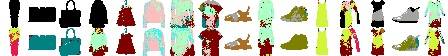

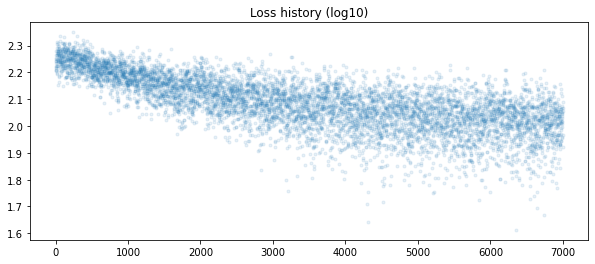

 step: 7143, log10(loss): 2.122

KeyboardInterrupt: ignored

In [19]:
# Training loop

@tf.function
def train_step(x, y):
  iter_n = 20
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = batch_l2_loss(x, y)
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(1, 100000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = np.copy(batch.x)
    y0 = batch.y
    # we want half of them new. We remove 1/4 from the top and 1/4 from the
    # bottom.
    q_bs = BATCH_SIZE // 4

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    x0[:q_bs] = ca.initialize(x_train[new_idx])
    y0[:q_bs] = y_train_pic[new_idx]

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    new_x, new_y = x_train[new_idx], y_train_pic[new_idx]
    if MUTATE_POOL:
      new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
      mutate_mask = tf.cast(new_x > 0.1, tf.float32)
      mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

      x0[-q_bs:] = mutated_x
      y0[-q_bs:] = new_y

    else:
      x0[-q_bs:] = ca.initialize(new_x)
      y0[-q_bs:] = new_y

  else:
    b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
    x0 = ca.initialize(x_train[b_idx])
    y0 = y_train_pic[b_idx]

  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0 # This gets reordered, so you need to change it.
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%100 == 0:
    generate_pool_figures(ca, pool, step_i)
  if step_i%200 == 0:
    clear_output()
    visualize_batch(ca, x0, x, step_i)
    plot_loss(loss_log)
  if step_i%10000 == 0:
    export_model(ca, 'train_log/%07d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [20]:
# useful code if you end up interrupting the run.
print(step_i)
export_model(ca, 'train_log/%07d'%step_i)

7142


In [12]:
# @title eval metrics
import sys
np.set_printoptions(threshold=sys.maxsize)

eval_batch = 1000
num_iters = 10

all_accuracies, all_agreements = eval_all(ca, num_steps=200, mutate=True)




pl.figure(figsize=(10, 4))
pl.title('Average cell accuracy over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average cell accuracy (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_accuracies, label="ca")
pl.legend()
pl.show()

pl.figure(figsize=(10, 4))
pl.title('Average total agreement across batch over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average total agreement (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_agreements, label="ca")
pl.legend()
pl.show()

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 53210.  28871.  63633.  32426.  57684.  18304.  54368.  22988.  44870.
   33116.]
 [ 28749. 114141.  70563.  37622.  49647.   7423.  34195.   2230.  24860.
   12686.]
 [ 67192.  39133.  81731.  55033.  89167.   7449.  68400.   6746.  41558.
   29240.]
 [  8757.   8281.  11205.   7858.  10740.   2371.   9244.   1745.   6773.
    4901.]
 [ 39656.  16949.  47777.  30437.  64202.   4169.  36704.   6427.  32494.
   25659.]
 [ 15475.   2572.  12373.   8153.   6395.  31602.  13689.  22468.  15397.
    9208.]
 [ 52354.  10338.  60980.  19445.  30417.   6899.  66231.   5823.  29234.
    8326.]
 [  5179.   1116.   4061.   2558.   2366.  12003.   4346.  11586.   5403.
    3975.]
 [116902.  32020. 124306.  60479. 144577.  28204. 107633.  51247. 128811.
   92445.]
 [ 58086.  15549.  54531.  32619.  64195.  50716.  42530.  85350.  70340.
   94994.]]
[[2.385420e+05 7.116900e+04 2.661730e+05 1.436790e+05 2.536550e+05
  4.247000e+04 2.337520e+05 4.791000e+04 1.919510e+05 6.832200e+04]
 [1.909150e+05

 10%|█         | 1/10 [01:13<10:57, 73.11s/it]

[[4.278940e+05 1.135520e+05 4.653460e+05 2.526450e+05 4.495330e+05
  6.726800e+04 3.897460e+05 7.520900e+04 3.309420e+05 1.070910e+05]
 [2.766270e+05 9.200611e+06 1.620794e+06 9.973400e+05 8.006380e+05
  3.928700e+04 4.716290e+05 7.218000e+03 1.218060e+05 5.516000e+04]
 [8.139106e+06 7.682920e+05 9.704972e+06 4.810611e+06 1.262747e+07
  5.734500e+04 6.591687e+06 3.490200e+04 3.555268e+06 2.825250e+05]
 [4.658240e+05 2.280730e+05 7.249530e+05 6.195250e+05 6.847210e+05
  1.591400e+04 4.085310e+05 7.537000e+03 1.612260e+05 3.653700e+04]
 [1.291509e+06 7.710100e+04 1.067692e+06 6.249170e+05 1.737563e+06
  1.708400e+04 9.094910e+05 2.334900e+04 1.306904e+06 1.263450e+05]
 [3.835730e+05 8.068200e+04 3.655230e+05 2.951180e+05 2.527110e+05
  4.319372e+06 2.502310e+05 3.338829e+06 5.746610e+05 1.080387e+06]
 [4.992112e+06 4.099080e+05 5.195003e+06 1.603331e+06 2.916537e+06
  5.219800e+04 5.013388e+06 3.083900e+04 2.347407e+06 7.522300e+04]
 [8.440400e+04 1.609200e+04 6.183500e+04 5.555800e+04 3

 20%|██        | 2/10 [02:27<09:49, 73.65s/it]

[[7.5778200e+05 1.9236500e+05 8.5233800e+05 4.9897000e+05 8.4885300e+05
  1.1181400e+05 7.8737800e+05 1.2457700e+05 6.6464800e+05 1.8494300e+05]
 [5.0525600e+05 1.7725566e+07 2.9270960e+06 2.0268820e+06 1.4723020e+06
  7.6602000e+04 8.2781200e+05 1.1284000e+04 2.9273200e+05 1.0870900e+05]
 [1.4677809e+07 1.4523020e+06 1.9734109e+07 1.0909264e+07 2.3551199e+07
  1.2275400e+05 1.3999024e+07 6.0105000e+04 7.0189720e+06 5.2419400e+05]
 [8.1606400e+05 4.4066500e+05 1.3947140e+06 1.3986630e+06 1.2815590e+06
  3.6917000e+04 7.8312500e+05 1.2183000e+04 3.3328800e+05 6.9609000e+04]
 [2.2828250e+06 1.3859100e+05 2.1861430e+06 1.3347750e+06 3.0942190e+06
  2.8768000e+04 1.9636040e+06 3.7929000e+04 2.4898340e+06 2.0918500e+05]
 [6.1227600e+05 1.3119700e+05 6.0543500e+05 4.6810900e+05 4.2717100e+05
  8.9724950e+06 6.5464600e+05 6.8517070e+06 1.3238500e+06 2.1157200e+06]
 [9.1615870e+06 6.1459200e+05 9.5786130e+06 3.1365950e+06 6.4657200e+06
  1.1326200e+05 1.1378201e+07 5.8110000e+04 5.0254840e+06 

 30%|███       | 3/10 [03:40<08:33, 73.37s/it]

[[1.1310710e+06 2.7506800e+05 1.2171780e+06 7.8503100e+05 1.1632810e+06
  1.5641000e+05 1.1783980e+06 1.7523000e+05 9.8035100e+05 2.7540300e+05]
 [7.7773100e+05 2.6253787e+07 4.1400180e+06 3.0838730e+06 2.0114510e+06
  1.1540900e+05 1.5269160e+06 1.5766000e+04 4.0337800e+05 1.6778600e+05]
 [2.1683121e+07 2.0699600e+06 2.6226994e+07 1.6298787e+07 3.3890084e+07
  1.8030800e+05 2.3039705e+07 8.8520000e+04 1.1205417e+07 8.3170000e+05]
 [1.2348370e+06 6.1560600e+05 1.8464300e+06 2.0514120e+06 1.8398510e+06
  5.5438000e+04 1.2643440e+06 1.7360000e+04 5.1641800e+05 1.1077600e+05]
 [3.4151350e+06 1.9394500e+05 2.8982040e+06 1.9328110e+06 4.4871270e+06
  4.0600000e+04 3.3297830e+06 5.4684000e+04 4.0442550e+06 3.1992800e+05]
 [9.2587400e+05 2.4365100e+05 9.7884300e+05 8.6859200e+05 5.4059500e+05
  1.2899984e+07 1.0009310e+06 9.8431520e+06 2.0262220e+06 3.1002650e+06]
 [1.4624255e+07 9.5620100e+05 1.6157385e+07 5.7655270e+06 8.8959550e+06
  2.3098700e+05 1.6653494e+07 8.4032000e+04 6.7618220e+06 

 40%|████      | 4/10 [04:55<07:22, 73.82s/it]


KeyboardInterrupt: ignored

In [ ]:
#@title training progress (batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

In [ ]:
#@title pool contents
#!rm -f train_log/*_pool.jpg

frames = sorted(glob.glob('train_log/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=5.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

## pretrained models

Please run the cell below to download pretrained models that are used to generate the subsequent figures. They are also used in the demo section.

In [ ]:
!wget -O models.zip 'https://github.com/google-research/self-organising-systems/blob/master/assets/mnist_ca/models.zip?raw=true'

In [ ]:
!unzip -oq "models.zip" -d "models"

In [ ]:
def get_exp_path(
    prefix, use_sample_pool, mutate_pool, loss_type, add_noise):
  path = prefix
  path += 'use_sample_pool_%r mutate_pool_%r '%(use_sample_pool, mutate_pool)
  path += 'loss_type_%s '%(loss_type)
  path += 'add_noise_%r'%(add_noise)
  path += '/0100000'
  return path

def get_model(use_sample_pool=True, mutate_pool=True, loss_type="l2", add_noise=True,
              prefix="models/", output='model'):
  path = get_exp_path(
      prefix, use_sample_pool, mutate_pool, loss_type, add_noise)
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel(add_noise=add_noise)
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

# Figures

In [ ]:
# @title mosaic of pictures

num_digits = 144

indexes = np.random.randint(0, x_train.shape[0]-1, size=num_digits)
figures = color_labels(x_train[indexes], y_train_pic[indexes], dtype=tf.float32)
tile_digits = generate_tiled_figures(figures, fade_by=0.1)

imshow(zoom(tile_digits))

## visualize runs

In [ ]:
!wget -O mnist_slider.png 'https://github.com/google-research/self-organising-systems/blob/master/assets/mnist_ca/mnist_slider.png?raw=true'

In [ ]:
def make_run_videos(ca, num_steps, eval_bs, prefix, disable_black=False):
  new_idx = np.random.randint(0, x_train.shape[0]-1, size=eval_bs)
  x = ca.initialize(x_train[new_idx])
  frames = []
  with VideoWriter(prefix + ".mp4") as vid:
    slider = PIL.Image.open("mnist_slider.png")
    for i in tqdm.trange(-1, num_steps):
      if i == -1:
        image = zoom(tile2d(classify_and_color(ca, x, disable_black=False)), scale=2)
      else:
        if i == num_steps//2:
          # then mutate
          new_idx = np.random.randint(0, x_train.shape[0]-1, size=eval_bs)
          new_x = x_train[new_idx]
          new_x = tf.reshape(new_x, [eval_bs, 28, 28, 1])
          mutate_mask = tf.cast(new_x > 0.1, tf.float32)
          x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)
        x = ca(x)
        image = zoom(tile2d(classify_and_color(ca, x, disable_black=disable_black)), scale=2)
      vis_extended = np.concatenate((image, np.ones((86, image.shape[1], 3))), axis=0) 
      im = np.uint8(vis_extended*255)
      im = PIL.Image.fromarray(im)
      im.paste(slider, box=(0, image.shape[0]+20))
      draw = PIL.ImageDraw.Draw(im)
      p_x = 3+(((image.shape[1]-5-3)/num_steps)*i)
      draw.rectangle([p_x, image.shape[0]+21, p_x+5, image.shape[0]+42], fill="#434343bd")
      vid.add(np.uint8(im))

In [ ]:
# @title visualize CE runs
eval_bs= 100
num_steps = 400 

ca = get_model(add_noise=False, loss_type='ce')
make_run_videos(ca, num_steps, eval_bs, "ce_runs", disable_black=True)
mvp.ipython_display('ce_runs.mp4')

In [ ]:
# @title visualize L2 runs
eval_bs= 100
num_steps = 400

ca = get_model(add_noise=True, loss_type='l2')
make_run_videos(ca, num_steps, eval_bs, "l2_runs")
mvp.ipython_display('l2_runs.mp4')

In [ ]:
# @title CE eval for experiment 1
# @title comparing

ca = get_model(add_noise=False, loss_type='ce')
label_1 = 'Cross Entropy'

all_accuracies, all_agreements = eval_all(ca, num_steps=200, mutate=True)

In [ ]:
pl.figure(figsize=(10, 4))

pl.title('Average cell accuracy over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average cell accuracy (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_accuracies, label=label_1)
pl.legend()
pl.show()

pl.figure(figsize=(10, 4))
pl.title('Average total agreement across batch over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average total agreement (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_agreements, label=label_1)
pl.legend()
pl.show()

In [ ]:
# @title comparing CE, L2, L2+noise
print("Evaluating CE:", flush=True)
ca = get_model(add_noise=False, loss_type='ce')
all_accuracies_1, all_agreements_1 = eval_all(ca, num_steps=200, mutate=True)

print("Evaluating L2:", flush=True)
ca = get_model(add_noise=False, loss_type='l2')
all_accuracies_2, all_agreements_2 = eval_all(ca, num_steps=200, mutate=True)

print("Evaluating L2 with noise:", flush=True)
ca = get_model(add_noise=True, loss_type='l2')
all_accuracies_3, all_agreements_3 = eval_all(ca, num_steps=200, mutate=True)

In [ ]:
def get_highest_point(arr):
  highest_i = 0
  highest_val = 0
  for i in range(len(arr)):
    if arr[i] > highest_val:
      highest_i = i
      highest_val = arr[i]
  return highest_i, highest_val

highest_i, highest_val = get_highest_point(all_accuracies_1[:200])
print("CE, top accuracy:", highest_i, highest_val)
highest_i, highest_val = get_highest_point(all_agreements_1[:200])
print("CE, top agreement:", highest_i, highest_val)

highest_i, highest_val = get_highest_point(all_accuracies_2[:200])
print("L2, top accuracy:", highest_i, highest_val)
highest_i, highest_val = get_highest_point(all_agreements_2[:200])
print("L2, top agreement:", highest_i, highest_val)


highest_i, highest_val = get_highest_point(all_accuracies_3[:200])
print("L2 with noise, top accuracy:", highest_i, highest_val)
highest_i, highest_val = get_highest_point(all_agreements_3[:200])
print("L2 with noise, top agreement:", highest_i, highest_val)

In [ ]:
label_1 = 'Cross Entropy'
label_2 = 'L2'
label_3 = 'L2 + Residual Noise'

pl.figure(figsize=(15, 10))
pl.subplot(211)
pl.title('Average cell accuracy over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average cell accuracy (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_accuracies_1, label=label_1)
pl.plot(all_accuracies_2, label=label_2)
pl.plot(all_accuracies_3, label=label_3)
pl.legend()

pl.subplot(212)
pl.title('Average total agreement across batch over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average total agreement (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_agreements_1, label=label_1)
pl.plot(all_agreements_2, label=label_2)
pl.plot(all_agreements_3, label=label_3)
pl.show()


## Internal states



In [ ]:
# @title Eval magnitude function

def eval_mag_perform_steps(ca, x, num_steps):
  m = x[...,:1]>0.1
  m_fl = tf.cast(m, tf.float32)
  m_sum = tf.reduce_sum(m_fl) * 19 # because there are 19 mutable states.

  # Update mask is known to be 50%, so we just know to divide the denominator
  # by 2:
  m_sum_active = m_sum / 2.

  state_magnitudes = []
  state_delta_magnitudes = []

  for _ in range(1, num_steps + 1):
    x_prev = x[..., 1:] # ignore the grey channel
    x = ca(x)

    # State magnitude
    # Ideally, these would have to be multiplied by the active mask, but
    # we know everything else is zero anyway.
    mutable_states = x[..., 1:]
    to_plot = tf.reduce_sum(tf.abs(mutable_states)) / m_sum
    state_magnitudes.append(to_plot.numpy().item())

    # deltas
    to_plot = tf.reduce_sum(tf.abs( mutable_states - x_prev)) / m_sum_active
    state_delta_magnitudes.append(to_plot.numpy().item())

  return state_magnitudes, state_delta_magnitudes

def eval_mag_batch_fn(ca, x_test, num_steps, mutate):
  x = ca.initialize(x_test)

  st_mag_l_1, st_delta_mag_l_1 = eval_mag_perform_steps(ca, x, num_steps)
  if not mutate:
    return st_mag_l_1, st_delta_mag_l_1
  # after mutation!
  new_idx = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
  new_x = x_test[new_idx]
  new_x = tf.reshape(new_x, [-1, 28, 28, 1])
  mutate_mask = tf.cast(new_x > 0.1, tf.float32)

  x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)

  st_mag_l_2, st_delta_mag_l_2 = eval_mag_perform_steps(ca, x, num_steps)

  return st_mag_l_1 +st_mag_l_2, st_delta_mag_l_1 + st_delta_mag_l_2

def eval_magnitude_all(ca, num_steps, mutate):
  all_magnitudes = []
  all_delta_magnitudes = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    mag_i, del_i = eval_mag_batch_fn(ca, x_set, num_steps, mutate)
    all_magnitudes.append(mag_i)
    all_delta_magnitudes.append(del_i)

  all_magnitudes = [sum(l)/num_batches for l in zip(*all_magnitudes)]
  all_delta_magnitudes = [sum(l)/num_batches for l in zip(*all_delta_magnitudes)]
  return all_magnitudes, all_delta_magnitudes


In [ ]:
# @title CE magnitude eval for experiment 1
# @title comparing

ca = get_model(add_noise=False, loss_type='ce')
ce_all_magnitudes, ce_all_delta_magnitudes = eval_magnitude_all(ca, num_steps=200, mutate=True)
pl_colorcycle = pl.rcParams['axes.prop_cycle'].by_key()['color']

pl.figure(figsize=(10, 4))
pl.xlabel('Number of steps')
pl.ylabel('Average magnitude')
pl.xlim(0, 400)
pl.ylim(0, 30)
pl.plot(ce_all_magnitudes, label="CE: state", color=pl_colorcycle[0])
pl.plot(ce_all_delta_magnitudes, label="CE: residual", color=pl_colorcycle[0], 
        linestyle="--")

pl.legend()
pl.show()


In [ ]:
# @title L2 magnitude eval for experiment 2
# @title comparing

ca = get_model(add_noise=False, loss_type='l2')

l2_all_magnitudes, l2_all_delta_magnitudes = eval_magnitude_all(ca, num_steps=200, mutate=True)

pl.figure(figsize=(10, 4))
pl.xlabel('Number of steps')
pl.xlim(0, 400)
pl.ylim(1e-2, 4e1)
pl.yscale("log")
pl.plot(l2_all_magnitudes, label="Average state magnitude")
pl.plot(l2_all_delta_magnitudes, label="Average residual magnitude")

pl.legend()
pl.show()

In [ ]:
# @title L2+ noise magnitude eval for experiment 2

ca = get_model(add_noise=True, loss_type='l2')

l2n_all_magnitudes, l2n_all_delta_magnitudes = eval_magnitude_all(ca, num_steps=200, mutate=True)

pl.figure(figsize=(10, 4))
pl.xlabel('Number of steps')
pl.xlim(0, 400)
pl.plot(l2n_all_magnitudes, label="Average state magnitude")
pl.plot(l2n_all_delta_magnitudes, label="Average residual magnitude")

pl.legend()
pl.show()

In [ ]:
# @title Observed state magnitudes of CE, L2, and L2 + noise

pl_colorcycle = pl.rcParams['axes.prop_cycle'].by_key()['color']

pl.figure(figsize=(10, 4))
pl.xlabel('Number of steps')
pl.ylabel('Average magnitude')
pl.xlim(0, 400)
pl.ylim(1e-2, 4e1)
pl.yscale("log")
pl.plot(ce_all_magnitudes, label="CE: state", color=pl_colorcycle[0])
pl.plot(ce_all_delta_magnitudes, label="CE: residual", color=pl_colorcycle[0], 
        linestyle="--")

pl.plot(l2_all_magnitudes, label="L2: state", color=pl_colorcycle[1])
pl.plot(l2_all_delta_magnitudes, label="L2: residual", color=pl_colorcycle[1],
        linestyle="--")

pl.plot(l2n_all_magnitudes, label="L2 + Noise: state", color=pl_colorcycle[2])
pl.plot(l2n_all_delta_magnitudes, label="L2 + Noise: residual", color=pl_colorcycle[2],
        linestyle="--")

pl.legend(loc="lower right")
pl.show()

## Internal states video for L2 model

In [ ]:
# @title internal states utils 
from skimage.transform import resize

def gen_clip_squasher(max_magnitude):
  def squasher(vis):
    vis = np.clip(vis, -max_magnitude, max_magnitude)
    return vis / max_magnitude
  return squasher

def vis_internal_states(x, squasher):
  vis = x.numpy().transpose([2, 0, 1])
  vis = tile2d(vis, 10)
  vis = squasher(vis)
  vis = zoom(pl.cm.RdBu_r((vis / (np.pi / 2)) / 2. + 0.5), 2)
  return vis

def get_color_bar(unsquasher, num_ticks, pixel_width=500):
  values = np.linspace(0, 1, 256)
  values2D = np.vstack((values, values))
  fig, ax = pl.subplots()
  fig.set_dpi(100)
  fig.set_figheight((pixel_width/100) * 0.05)
  fig.set_figwidth(pixel_width/100)
  ax.imshow(values2D, aspect='auto', cmap=pl.cm.get_cmap("RdBu_r"))
  ax.set_xticks(np.linspace(0,255,num_ticks))
  ax.get_yaxis().set_visible(False)
  ax.xaxis.tick_top()
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  labels = np.linspace(0,1,num_ticks)
  labels = (np.pi / 2) * (2.0 * (labels - 0.5)) 
  labels = unsquasher(labels)
  labels = ["%.1f" % x for x in labels]
  labels[0] = "-∞"
  labels[-1] = "∞"
  ax.set_xticklabels(labels)
  fig.savefig("colorbar.jpg", bbox_inches='tight')
  pl.close()
  plt_image = PIL.Image.open("colorbar.jpg")
  final_output = PIL.Image.new("RGB", (pixel_width, plt_image.height), (255, 255, 255))
  final_output.paste(plt_image, (112+int(((pixel_width-112)-plt_image.width)//2), 0))
  return final_output 

def vis_for_video(x, squasher, legend=None):
  vis = vis_internal_states(x, squasher)
  current_prediction = classify_and_color(ca, tf.expand_dims(x, 0), disable_black=True)[0]
  above_part = zoom(current_prediction, 10)
  above_part = resize(above_part, (vis.shape[1], vis.shape[1]))
  # add A channel
  above_part = np.concatenate([above_part, np.ones_like(above_part[...,:1])], -1)
  vis = np.vstack([above_part, vis])
  if legend is not None:
    l_h = legend.shape[1] * vis.shape[0] // legend.shape[0]
    if l_h % 2 == 1:  l_h += 1
    legend = resize(legend, (vis.shape[0], l_h))
    vis = np.hstack([vis, legend])
  return vis

def vis_for_video_horiz(x, squasher):
  vis = vis_internal_states(x, squasher)
  current_prediction = classify_and_color(ca, tf.expand_dims(x, 0), disable_black=True)[0]
  left_part = zoom(current_prediction, 4)
  # add A channel
  left_part = np.concatenate([left_part, np.ones_like(left_part[...,:1])], -1)
  vis = np.hstack([left_part, vis])
  return vis

In [ ]:
!wget -O states_slider.png 'https://github.com/google-research/self-organising-systems/blob/master/assets/mnist_ca/states_slider.png?raw=true'

In [ ]:
# @title L2 internal states
figure_name = "l2n_horiz_states"

legend = numbers_legend
# need to add the A channel.
legend = np.concatenate([legend, np.ones_like(legend[...,:1])], -1)

#squasher = gen_clip_squasher(2.0)
squasher = np.arctan
unsquasher = np.tan

placement_style = "horiz" # "vertic"

num_mutations = 5
speedup_after = 50
speedup_by = 10

x_set = x_test
y_set = y_test_pic

ca = get_model(add_noise=True, loss_type='l2')
frames = []
width = 2*(28*10 + 2*28)

colorbar = get_color_bar(unsquasher, 17, width)
states_slider = PIL.Image.open("states_slider.png")

progress = 0
with VideoWriter(figure_name + ".mp4", fps=20.0) as vid:
  for m in tqdm.trange(num_mutations + 1):
    if m == 0:
      b_idx = np.random.randint(0, x_set.shape[0]-1, size=1)
      x0 = ca.initialize(x_train[b_idx])
    else:
      # mutate
      b_idx = np.random.randint(0, x_set.shape[0]-1, size=1)
      new_x = x_set[b_idx]
      new_x = tf.reshape(new_x, [-1, 28, 28, 1])
      mutate_mask = tf.cast(new_x > 0.1, tf.float32)
      x0 = tf.concat([new_x, x0[:,:,:,1:] * mutate_mask], -1)
    
    for i in range(0, 200):
      if i < speedup_after or i % speedup_by == 0:
        vis = (vis_for_video_horiz(x0[0], squasher) if placement_style == "horiz" else
          vis_for_video(x0[0], squasher, legend))
        states_slider_progress = states_slider.copy()
        draw = PIL.ImageDraw.Draw(states_slider_progress)
        p_x = int(progress/((num_mutations+1) * 200) * width)
        draw.rectangle([p_x, 0, p_x+5, states_slider_progress.height], fill="#434343bd")
        vid.add(np.vstack((np.asarray(colorbar), 
                           np.uint8(vis[..., :3]*255.0),
                           np.uint8(np.ones((10, width, 3))*255.0), 
                           np.asarray(states_slider_progress))))
      progress += 1
      x0 = ca(x0)

mvp.ipython_display(figure_name + '.mp4')

# Demo


In [ ]:
# @title Create the data for the distill demo

def create_numbers_legend(x_set, y_set, y_set_pic):
  result_y = []
  for i in range(10):
    for x, y, y_pic in zip(x_set, y_set, y_set_pic):
      if y == i:
        result_y.append(color_labels(x, y_pic))
        break
  assert len(result_y) == 10
  return tile2d(np.stack(result_y), 5)


def find_several_numbers(x_set, y_set, num_each):
  result = []
  for i in range(10):
    i_numbers = []
    n = 0
    for x, y in zip(x_set, y_set):
      if y == i:
        i_numbers.append(x)
        n += 1
        if n == num_each: break
    result.append(np.stack(i_numbers))
  return np.stack(result)

demo_numbers_legend = create_numbers_legend(x_train, y_train, y_train_pic)

n = 20
demo_samples = find_several_numbers(x_train, y_train, n)
print(demo_samples.shape)
demo_samples = np.concatenate([tile2d(dsi, n) for dsi in demo_samples], 0)
print(demo_samples.shape)

imshow(zoom(demo_numbers_legend))
im = PIL.Image.fromarray(zoom(demo_numbers_legend))
im.save("demo_numbers_legend.png")

print("Storing demo_samples for use in the demo.")
import json
many_samples_str = json.dumps(demo_samples.tolist())
print(len(many_samples_str))

pl.imshow(demo_samples)
demo_samples *= 255.
im = PIL.Image.fromarray(demo_samples.astype(np.uint8)).convert("L")
im.save("demo_samples.png")


In [ ]:
#@title TensorFlow.js Demo small {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running 
#@markdown cells from the "Training" section of this notebook.
#@markdown Technical note: CE models should be rendered differently to avoid
#@markdown black pixels showing for low magnitude.
import IPython.display

model_source = "LOAD"  #@param ['CHECKPOINT', 'LOAD']
model_type = '3 mutating'  #@param ['1 naive', '2 persistent', '3 mutating']
loss_type = "l2"  #@param ['l2', 'ce']
add_noise = "True"  #@param ['True', 'False']
#quant_states = "True"  #@param ['True', 'False']

#@markdown draw with left click, hold shift for erasing

if model_source != 'CHECKPOINT':
  use_sample_pool, mutate_pool = {
      '1 naive': (False, False),
      '2 persistent': (True, False),
      '3 mutating': (True, True)
      }[model_type]
  add_noise = add_noise == 'True'

  model_str = get_model(
      use_sample_pool=use_sample_pool, mutate_pool=mutate_pool,
      loss_type=loss_type, add_noise=add_noise,
      output='json')
else:
  last_checkpoint_fn = sorted(glob.glob('train_log/*.json'))[-1]
  model_str = open(last_checkpoint_fn).read()

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
  window.SAMPLES = %s
'''%(model_str, samples_str)

display(IPython.display.Javascript(data_js))


IPython.display.HTML('''
<script src=\"https://unpkg.com/@tensorflow/tfjs@latest/dist/tf.min.js\"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/cash/4.1.2/cash.min.js"></script>
<div class="slidecontainer">
    brushSize:
    <input type="range" min="1" max="10" value="4" class="slider" id="brushSlider">
    <span id='radius'>2.5</span>
</div>
<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>
<script>
  "use strict";

  // Adds the WASM backend to the global backend registry.
  //import '@tensorflow/tfjs-backend-wasm';
  // Set the backend to WASM and wait for the module to be ready.
const main = async () => {

  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));
  
  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        const shape = v.tensorShape.dim.map(d=>parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          arr.fill(v[field][0]);
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  let paused = false;
  let visibleChannel = -1;
  let firingChance = 0.5;
  let drawRadius = 2.5;

  $('#brushSlider').on('input', e=>{
      drawRadius = parseFloat(e.target.value)/2.0;
      $('#radius').text(drawRadius);
  });

  const colorLookup = tf.tensor([
      [128, 0, 0],
      [230, 25, 75],
      [70, 240, 240],
      [210, 245, 60],
      [250, 190, 190],
      [170, 110, 40],
      [170, 255, 195],
      [165, 163, 159],
      [0, 128, 128],
      [128, 128, 0],
      [0, 0, 0], // This is the default for digits.
      [255, 255, 255] // This is the background.
      ])

  let backgroundWhite = true;


  const run = async () => {
      const r = await fetch(GRAPH_URL);
      const consts = parseConsts(await r.json());

      //const samples = tf.tensor(SAMPLES);
      //console.log(samples);

      const model = await tf.loadGraphModel(GRAPH_URL);

      const samples = tf.tensor(SAMPLES);
      console.log(samples.shape);
      //const samples = tf.zeros([2,5, 28, 28]);

      console.log("Loaded model")
      Object.assign(model.weights, consts);
      // samples.gather(tf.range(0, 4, 1, 'int32')
      const D = 28 * 2;
      const state = tf.variable(tf.zeros([1, D, D, 20]));
      const [_, h, w, ch] = state.shape;

      const scale = 8;

      const canvas = document.getElementById('canvas');
      const ctx = canvas.getContext('2d');
      canvas.width = w * scale;
      canvas.height = h * scale;

      const drawing_canvas = new OffscreenCanvas(w, h);
      const draw_ctx = drawing_canvas.getContext('2d');

      // Useful for understanding background color.
      
      //let blackAndWhite = tf.zeros();//.fill(0.01);
      let arr = new Float32Array(h * w * 2);
      arr.fill(0.01);
      const blackAndWhiteFull = tf.tensor(arr, [1,h,w,2], tf.float32)

      const drawCanvas = (imgd, e) => {
          var matrix = [];
          for(let i=0; i<imgd.width; i++) {
              matrix[i] = [];
              for(let j=0; j<imgd.height; j++) {
                  let intensity = imgd.data[(imgd.height*j*4 + i*4)];
                  // For drawing, we want to add shades of grey. For erasing, we don't.
                  if (!e.shiftKey) {
                    intensity *= (imgd.data[(imgd.height*j*4 + i*4 + 3)] / 255);
                  }
                  matrix[i][j] = intensity;
              }
          }

          tf.tidy(() => {
              const stroke = tf.tensor(matrix).transpose().toFloat().div(255.).expandDims(0).expandDims(3);
              const stroke_pad = tf.concat([stroke, tf.zeros([1, h, w, ch-1])], 3);
              const mask = tf.tensor(1.).sub(stroke);
              if (e.shiftKey) {
                  state.assign(state.mul(mask));
              } else {
                  state.assign(state.mul(mask).add(stroke_pad));
              }
          });

          // Then clear the canvas.
          draw_ctx.clearRect(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
      }

      const line = (x0, y0, x1, y1, r, e) => {
          draw_ctx.beginPath();
          draw_ctx.moveTo(x0, y0);
          draw_ctx.lineTo(x1, y1);
          draw_ctx.strokeStyle = "#ff0000";
          // Erasing has a much larger radius.
          draw_ctx.lineWidth = (e.shiftKey ? 5. * r : r);
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }


      const circle = (x, y, r, e) => {
          draw_ctx.beginPath();

          const drawRadius = (e.shiftKey ? 5. * r : r) / 3.;

          draw_ctx.arc(x, y, drawRadius, 0, 2 * Math.PI, false);
          draw_ctx.fillStyle = "#ff0000";
          draw_ctx.fill();
          draw_ctx.lineWidth = 1;
          draw_ctx.strokeStyle = "#ff0000";
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }

      const draw_r = 2.0;


      const getClickPos = e=>{
          const x = Math.floor((e.pageX-e.target.offsetLeft) / scale);
          const y = Math.floor((e.pageY-e.target.offsetTop) / scale);
          return [x, y];
      }

      let lastX = 0;
      let lastY = 0;

      canvas.onmousedown = e => {
          const [x, y] = getClickPos(e);
          lastX = x;
          lastY = y;
          circle(x,y,drawRadius, e);
      }
      canvas.onmousemove = e => {
          const [x, y] = getClickPos(e);
          if (e.buttons == 1) {
              line(lastX,lastY, x,y,drawRadius, e);
          }
          lastX = x;
          lastY = y;
      }
      const render = async () => {
        if (!paused) {
          tf.tidy(() => {
              state.assign(model.execute(
                { x: state,
                  fire_rate: tf.tensor(firingChance),
                  manual_noise: tf.randomNormal([1, h, w, ch-1], 0., 0.02)},
                ['Identity']));
          });
        }
        const imageData = tf.tidy(() => {
            let rgbaBytes;
            let rgba;
            if (visibleChannel < 0) {
                const isGray = state.slice([0,0,0,0],[1, h, w, 1]).greater(0.1).toFloat();
                const isNotGray = tf.tensor(1.).sub(isGray);

                const bnwOrder = backgroundWhite ?  [isGray, isNotGray] : [isNotGray, isGray];
                let blackAndWhite = blackAndWhiteFull.mul(tf.concat(bnwOrder, 3));

                const grey = state.gather([0], 3).mul(255);
                const rgb = tf.gather(colorLookup,
                                      tf.argMax(
                                      tf.concat([
                  state.slice([0,0,0,ch-10],[1,h,w,10]),
                  blackAndWhite], 3), 3));

                rgba = tf.concat([rgb, grey], 3)
            } else {
                rgba = state.gather([visibleChannel, visibleChannel, visibleChannel], 3)
                  .pad([[0, 0], [0, 0], [0, 0], [0, 1]], 1).mul(255);
            }
            rgbaBytes = new Uint8ClampedArray(rgba.dataSync());

            return new ImageData(rgbaBytes, w, h);
        });
        const image = await createImageBitmap(imageData);
        //ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillStyle = backgroundWhite ? "#ffffff" : "#000000";
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        ctx.imageSmoothingEnabled = false;
        ctx.drawImage(image, 0, 0, canvas.width, canvas.height);

        requestAnimationFrame(render);
      }
      render();
  }

  run();
}
main();
  //tf.setBackend('wasm').then(() => main());

  
</script>
''')

In [ ]:
#@title TensorFlow.js Demo Full whiteboard {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running 
#@markdown cells from the "Training" section of this notebook.
#@markdown Technical note: CE models should be rendered differently to avoid
#@markdown black pixels showing for low magnitude.
import IPython.display

model_source = "LOAD"  #@param ['CHECKPOINT', 'LOAD']
model_type = '3 mutating'  #@param ['1 naive', '2 persistent', '3 mutating']
loss_type = "l2"  #@param ['l2', 'ce']
add_noise = "True"  #@param ['True', 'False']
#quant_states = "True"  #@param ['True', 'False']

#@markdown draw with left click, hold shift for erasing

if model_source != 'CHECKPOINT':
  use_sample_pool, mutate_pool = {
      '1 naive': (False, False),
      '2 persistent': (True, False),
      '3 mutating': (True, True)
      }[model_type]
  add_noise = add_noise == 'True'

  model_str = get_model(
      use_sample_pool=use_sample_pool, mutate_pool=mutate_pool,
      loss_type=loss_type, add_noise=add_noise,
      output='json')
else:
  last_checkpoint_fn = sorted(glob.glob('train_log/*.json'))[-1]
  model_str = open(last_checkpoint_fn).read()

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
  window.SAMPLES = %s
'''%(model_str, samples_str)

display(IPython.display.Javascript(data_js))


IPython.display.HTML('''
<script src=\"https://unpkg.com/@tensorflow/tfjs@latest/dist/tf.min.js\"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/cash/4.1.2/cash.min.js"></script>
<div class="slidecontainer">
    brushSize:
    <input type="range" min="1" max="10" value="4" class="slider" id="brushSlider">
    <span id='radius'>2.5</span>
</div>
<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>
<script>
  "use strict";

  // Adds the WASM backend to the global backend registry.
  //import '@tensorflow/tfjs-backend-wasm';
  // Set the backend to WASM and wait for the module to be ready.
const main = async () => {

  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));
  
  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        const shape = v.tensorShape.dim.map(d=>parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          arr.fill(v[field][0]);
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  let paused = false;
  let visibleChannel = -1;
  let firingChance = 0.5;
  let drawRadius = 2.5;

  $('#brushSlider').on('input', e=>{
      drawRadius = parseFloat(e.target.value)/2.0;
      $('#radius').text(drawRadius);
  });

  const colorLookup = tf.tensor([
      [128, 0, 0],
      [230, 25, 75],
      [70, 240, 240],
      [210, 245, 60],
      [250, 190, 190],
      [170, 110, 40],
      [170, 255, 195],
      [165, 163, 159],
      [0, 128, 128],
      [128, 128, 0],
      [0, 0, 0], // This is the default for digits.
      [255, 255, 255] // This is the background.
      ])

  let backgroundWhite = true;


  const run = async () => {
      const r = await fetch(GRAPH_URL);
      const consts = parseConsts(await r.json());

      //const samples = tf.tensor(SAMPLES);
      //console.log(samples);

      const model = await tf.loadGraphModel(GRAPH_URL);

      const samples = tf.tensor(SAMPLES);
      //const samples = tf.zeros([2,5, 28, 28]);

      console.log("Loaded model")
      Object.assign(model.weights, consts);
      // samples.gather(tf.range(0, 4, 1, 'int32')
      const D = 28 * 5;
      const flatState = tf.concat([
        samples.reshape([2,5, 28, 28])
          .transpose([0,2,1,3]).reshape([1, 2 * 28, D]),
        tf.zeros([1, D-(28*2), D])],1);
      console.log(flatState)
      const state = tf.variable(
        tf.concat([flatState.expandDims(3),
                    tf.zeros([1, D, D, 19])], 3));
      const [_, h, w, ch] = state.shape;

      const scale = 8;

      const canvas = document.getElementById('canvas');
      const ctx = canvas.getContext('2d');
      canvas.width = w * scale;
      canvas.height = h * scale;

      const drawing_canvas = new OffscreenCanvas(w, h);
      const draw_ctx = drawing_canvas.getContext('2d');

      // Useful for understanding background color.
      
      //let blackAndWhite = tf.zeros();//.fill(0.01);
      let arr = new Float32Array(h * w * 2);
      arr.fill(0.01);
      const blackAndWhiteFull = tf.tensor(arr, [1,h,w,2], tf.float32)

      const drawCanvas = (imgd, e) => {
          var matrix = [];
          for(let i=0; i<imgd.width; i++) {
              matrix[i] = [];
              for(let j=0; j<imgd.height; j++) {
                  let intensity = imgd.data[(imgd.height*j*4 + i*4)];
                  // For drawing, we want to add shades of grey. For erasing, we don't.
                  if (!e.shiftKey) {
                    intensity *= (imgd.data[(imgd.height*j*4 + i*4 + 3)] / 255);
                  }
                  matrix[i][j] = intensity;
              }
          }

          tf.tidy(() => {
              const stroke = tf.tensor(matrix).transpose().toFloat().div(255.).expandDims(0).expandDims(3);
              const stroke_pad = tf.concat([stroke, tf.zeros([1, h, w, ch-1])], 3);
              const mask = tf.tensor(1.).sub(stroke);
              if (e.shiftKey) {
                  state.assign(state.mul(mask));
              } else {
                  state.assign(state.mul(mask).add(stroke_pad));
              }
          });

          // Then clear the canvas.
          draw_ctx.clearRect(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
      }

      const line = (x0, y0, x1, y1, r, e) => {
          draw_ctx.beginPath();
          draw_ctx.moveTo(x0, y0);
          draw_ctx.lineTo(x1, y1);
          draw_ctx.strokeStyle = "#ff0000";
          // Erasing has a much larger radius.
          draw_ctx.lineWidth = (e.shiftKey ? 5. * r : r);
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }


      const circle = (x, y, r, e) => {
          draw_ctx.beginPath();

          const drawRadius = (e.shiftKey ? 5. * r : r) / 3.;

          draw_ctx.arc(x, y, drawRadius, 0, 2 * Math.PI, false);
          draw_ctx.fillStyle = "#ff0000";
          draw_ctx.fill();
          draw_ctx.lineWidth = 1;
          draw_ctx.strokeStyle = "#ff0000";
          draw_ctx.stroke();

          const imgd = draw_ctx.getImageData(0, 0, draw_ctx.canvas.width, draw_ctx.canvas.height);
          drawCanvas(imgd, e);
      }

      const draw_r = 2.0;


      const getClickPos = e=>{
          const x = Math.floor((e.pageX-e.target.offsetLeft) / scale);
          const y = Math.floor((e.pageY-e.target.offsetTop) / scale);
          return [x, y];
      }

      let lastX = 0;
      let lastY = 0;

      canvas.onmousedown = e => {
          const [x, y] = getClickPos(e);
          lastX = x;
          lastY = y;
          circle(x,y,drawRadius, e);
      }
      canvas.onmousemove = e => {
          const [x, y] = getClickPos(e);
          if (e.buttons == 1) {
              line(lastX,lastY, x,y,drawRadius, e);
          }
          lastX = x;
          lastY = y;
      }
      const render = async () => {
        if (!paused) {
          tf.tidy(() => {
              state.assign(model.execute(
                { x: state,
                  fire_rate: tf.tensor(firingChance),
                  manual_noise: tf.randomNormal([1, h, w, ch-1], 0., 0.02)},
                ['Identity']));
          });
        }
        const imageData = tf.tidy(() => {
            let rgbaBytes;
            let rgba;
            if (visibleChannel < 0) {
                const isGray = state.slice([0,0,0,0],[1, h, w, 1]).greater(0.1).toFloat();
                const isNotGray = tf.tensor(1.).sub(isGray);

                const bnwOrder = backgroundWhite ?  [isGray, isNotGray] : [isNotGray, isGray];
                let blackAndWhite = blackAndWhiteFull.mul(tf.concat(bnwOrder, 3));

                const grey = state.gather([0], 3).mul(255);
                const rgb = tf.gather(colorLookup,
                                      tf.argMax(
                                      tf.concat([
                  state.slice([0,0,0,ch-10],[1,h,w,10]),
                  blackAndWhite], 3), 3));

                rgba = tf.concat([rgb, grey], 3)
            } else {
                rgba = state.gather([visibleChannel, visibleChannel, visibleChannel], 3)
                  .pad([[0, 0], [0, 0], [0, 0], [0, 1]], 1).mul(255);
            }
            rgbaBytes = new Uint8ClampedArray(rgba.dataSync());

            return new ImageData(rgbaBytes, w, h);
        });
        const image = await createImageBitmap(imageData);
        //ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillStyle = backgroundWhite ? "#ffffff" : "#000000";
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        ctx.imageSmoothingEnabled = false;
        ctx.drawImage(image, 0, 0, canvas.width, canvas.height);

        requestAnimationFrame(render);
      }
      render();
  }

  run();
}
main();
  //tf.setBackend('wasm').then(() => main());

  
</script>
''')